## 사용자 불만 접수 원인 분석

In [261]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
font = {'size': 16, 'family':"Malgun Gothic"}
matplotlib.rc('font', **font)
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False

data_path = 'data/'
N_ERRTYPE = 42
img_save = False

### 1. Error 데이터

### 학습데이터 로드 및 전처리

In [230]:
train_err = pd.read_csv(data_path + 'train_err_data.csv')
train_err.drop_duplicates(inplace=True)
train_err = train_err.reset_index(drop=True)
train_err['time'] = pd.to_datetime(train_err['time'], format='%Y%m%d%H%M%S')
train_prob = pd.read_csv(data_path + 'train_problem_data.csv')
train_prob['time'] = pd.to_datetime(train_prob['time'], format='%Y%m%d%H%M%S')
train_prob['time_day'] = train_prob['time'].dt.day
train_prob['time_hour'] = train_prob['time'].dt.hour
# del train_prob['time']

problem_arr = np.zeros((15000, 30), dtype=int)
for i in range(train_prob.shape[0]):
    user_id = train_prob.loc[i,'user_id']
    time_day = train_prob.loc[i, 'time_day']
    problem_arr[user_id - 10000, time_day-1] += 1

### 데이터 transformation: Error data를 일별로 count

In [231]:
from main import *

# error code encoder load
encoder = get_encoder()
errcode_names = encoder.classes_

# 유저별로 processing하고 concatenate
err_df_in_day_user = split_error_data_in_day(train_err, 'train')
data_list = []
for user_idx in range(15000):
    data_list.append(err_df_in_day_user[user_idx])

err_list = []
for data in tqdm(data_list):
    err_list.append(transform_errtype(data))
err_arr = np.array(err_list)

err_df = extract_err(err_arr, WINDOW=1)

# 각각이 어떤 feature인지
data_cols = []
for i in range(N_NEW_ERRCODE):
    data_cols.append('errorcode_' + errcode_names[i])
for i in range(N_ERRTYPE):
    data_cols.append('errortype_'+ str(i+1))
data_cols.append('errortype_38_code_summation')

# 제외하고 분석할 error code 제외
drop_codes = ['errorcode_'+ str(c) + '-' for c in [10, 11, 12, 13, 15, 16, 18, 19, 20, 21, 22, 24, 26, 27, 28, 35, 36, 41]]

remaining_idx = []
for i in range(err_arr.shape[2]):
    flag = True
    for drop_code in drop_codes:
        if drop_code in data_cols[i]:
            flag = False
            break
    if flag:
        remaining_idx.append(i)

err_arr = err_arr[:,:,remaining_idx]
data_cols = np.array(data_cols)[remaining_idx]

N_FEATURES = len(data_cols)

feature = []
for i in range(err_df.shape[1]):
    remain = True
    col = err_df.columns[i]
    for code in drop_codes:
        if code in col:
            remain = False
            break
    if remain:
        feature.append(err_df[col])
feature = pd.concat(feature, axis=1)

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 12437/15000 [04:08<00:45, 56.26it/s]

UNKNOWN error code for type 5 :: http


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:58<00:00, 50.33it/s]


### 에러 발생량과 사용자 불만 여부와 상관관계

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


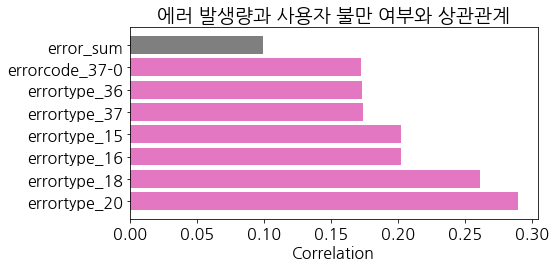

In [232]:
corr_result = []
# 전체 error code와 type 개별적으로
for err_idx in range(N_FEATURES):
    err_arr_sub = err_arr[:,:,err_idx]
    corr_result.append(np.corrcoef(problem_arr.sum(axis=1), err_arr_sub.sum(axis=1))[0,1])
corr_result = np.array(corr_result)

# nan 제거
nan_idx = np.isnan(corr_result)
corr_result = corr_result[~nan_idx]
columns = np.array(data_cols)
columns = columns[~nan_idx]

# 높은 순서대로 sorting
idx = np.argsort(corr_result)[::-1]
corr_result = corr_result[idx]
columns = columns[idx]

NUM_SHOW = 7
corr_result = corr_result[:NUM_SHOW]
columns = columns[:NUM_SHOW]

# plot
plt.figure(figsize=(8,4))
plt.barh(range(NUM_SHOW), corr_result, color='tab:pink')

# 전체 error type의 sum
err_arr_sub = err_arr[:,:,-N_ERRTYPE-1:-1]
sum_corr = np.corrcoef(problem_arr.sum(axis=1), err_arr_sub.sum(axis=2).sum(axis=1))[0,1]

plt.barh([NUM_SHOW], [sum_corr], color='tab:gray')
plt.yticks(range(NUM_SHOW+1), np.append(columns, 'error_sum'))
plt.xlabel('Correlation')
plt.title('에러 발생량과 사용자 불만 여부와 상관관계')
plt.tight_layout()
if img_save:
    plt.savefig('에러 발생량과 사용자 불만 여부와 상관관계.png', dpi=100)
plt.show()

### 불만 제기 여부에 따른 하루 평균 에러 발생량

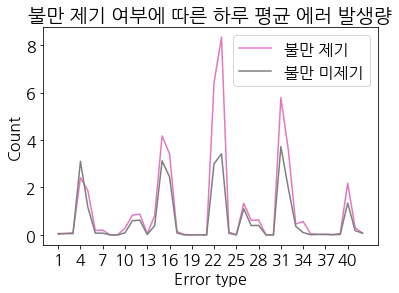

In [233]:
import seaborn as sns

# 에러 타입의 전체 합계
err_arr_sub = err_arr[:,:,-N_ERRTYPE-1:-1]

# 문제가 발생한 유저와 발생하지 않은 유저로 분리
problem_user = (problem_arr.sum(axis=1) > 0)
problem_0_err = err_arr_sub[problem_user,:,:]
problem_1_err = err_arr_sub[~problem_user,:,:]

# 유저당 일별 평균값 산출
problem_0_err = problem_0_err.mean(axis=0).mean(axis=0)
problem_1_err = problem_1_err.mean(axis=0).mean(axis=0)

plt.figure(figsize=(6,4))
plt.plot(problem_0_err, label='불만 제기', color='tab:pink')
plt.plot(problem_1_err, label='불만 미제기', color='tab:gray')
plt.xlabel('Error type')
plt.ylabel('Count')
plt.title('불만 제기 여부에 따른 하루 평균 에러 발생량')
plt.xticks(range(42)[::3], range(1,43)[::3])
plt.legend()
plt.show()

### 모델별 불만 발생량

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [00:26<00:00, 563.18it/s]


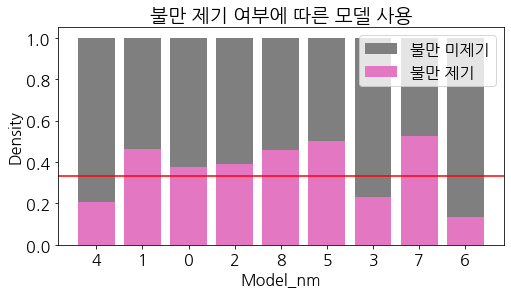

In [234]:
# model 관련 피쳐 생성
model_list = []
for data in tqdm(data_list):
    model_list.append(transform_model_nm(data))
model_arr = np.array(model_list)
model_df = extract_model_nm(model_arr, range(10000,25000))

density = []
for i in range(9):
    model_idx = (model_df['model_'+str(i)] == 1).values
    problem_user_model = problem_user[model_idx]
    density.append(problem_user_model.mean())
density = np.array(density)

plt.figure(figsize=(8,4))
model_sort_order =  np.array([4, 1, 0, 2, 8, 5, 3, 7, 6])
plt.bar(range(9), [1] * 9, color='tab:gray', label='불만 미제기')
plt.axhline(y=1/3, color='r', linestyle='-')
plt.bar(range(9), density[model_sort_order], color='tab:pink', label='불만 제기')
plt.xticks(range(9), model_sort_order)
plt.xlabel('Model_nm')
plt.ylabel('Density')
plt.legend()
plt.title('불만 제기 여부에 따른 모델 사용')
plt.show()


### 펌웨어별 불만 발생

  1%|█▌                                                                                                                                                                                         | 122/15000 [00:00<00:24, 598.60it/s]

Extract features from fwver...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [00:28<00:00, 521.89it/s]


Extract features from fwver is done


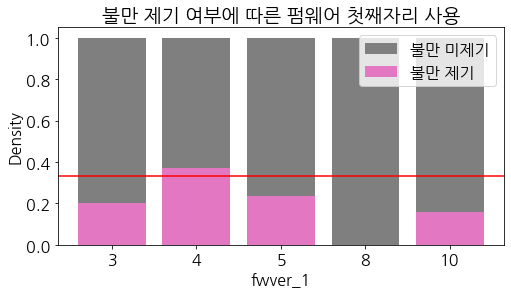

In [235]:
print('Extract features from fwver...')
fwver_list = []
for data in tqdm(data_list):
    fwver_list.append(transform_fwver(data))
fwver_arr = np.array(fwver_list)
id_list = range(10000, 25000)
fwver_arr = fwver_arr.astype(int)
fwver_diff = np.zeros((len(id_list), 3), dtype=int)
fwver_start = np.zeros((len(id_list), 3), dtype=int)
fwver_end = np.zeros((len(id_list), 3), dtype=int)
fwver_upgrade = np.zeros((len(id_list), 3), dtype=int)
fwver_downgrade = np.zeros((len(id_list), 3), dtype=int)

# 각 user마다
for i in range(len(id_list)):
    for j in range(3):
        data_sub = fwver_arr[i][:, j]
        data_sub = data_sub[data_sub != 0]

        # fwver diff
        fwver_diff[i, j] = np.max([len(np.unique(data_sub)) - 1, 0])
        occur_idx = np.where(data_sub)[0]
        if occur_idx.size == 0:
            continue

        # fwver start
        first_occur_idx = occur_idx[0]
        fwver_class_start = data_sub[first_occur_idx]
        fwver_start[i, j] = fwver_class_start

        # fwver end
        last_occur_idx = occur_idx[-1]
        fwver_class_end = data_sub[last_occur_idx]
        fwver_end[i, j] = fwver_class_end

        # fwver upgrade or downgrade
        fwver_upgrade[i, j] = fwver_class_start < fwver_class_end
        fwver_downgrade[i, j] = (fwver_class_start > fwver_class_end) * -1

fwver_df = pd.DataFrame()
for j in range(3):
    fwver_df['fwver_diff_' + str(j)] = fwver_diff[:, j]
    fwver_df['fwver_start_' + str(j)] = pd.Series(fwver_start[:, j])
    fwver_df['fwver_end_' + str(j)] = pd.Series(fwver_end[:, j])
    fwver_df['fwver_upgrade_' + str(j)] = pd.Series(fwver_upgrade[:, j])
    fwver_df['fwver_downgrade_' + str(j)] = pd.Series(fwver_downgrade[:, j])
fwver_df['fwver_start'] = fwver_df['fwver_start_0'].astype(str)+'.' + fwver_df['fwver_start_1'].astype(str)+'.' + fwver_df['fwver_start_2'].astype(str)
fwver_df['fwver_end'] = fwver_df['fwver_end_0'].astype(str)+'.' + fwver_df['fwver_end_1'].astype(str)+'.' + fwver_df['fwver_end_2'].astype(str)

print('Extract features from fwver is done')

unique_fwver_1 = np.unique(fwver_df['fwver_start_0'])
density = []
for fwver in unique_fwver_1:
    fwver_idx = (fwver_df['fwver_start_0'] == fwver).values
    problem_user_fwver = problem_user[fwver_idx]
    density.append(problem_user_fwver.mean())
density = np.array(density)

N_FWVER_1 = len(unique_fwver_1)
plt.figure(figsize=(8,4))
plt.bar(range(N_FWVER_1), [1] * N_FWVER_1, color='tab:gray', label='불만 미제기')
plt.axhline(y=1/3, color='r', linestyle='-')
plt.bar(range(N_FWVER_1), density, color='tab:pink', label='불만 제기')
plt.xticks(range(N_FWVER_1), unique_fwver_1)
plt.xlabel('fwver_1')
plt.ylabel('Density')
plt.legend()
plt.title('불만 제기 여부에 따른 펌웨어 첫째자리 사용')
plt.show()

### 모델이나 펌웨어 변경 여부에 따른 불만 발생률

In [236]:
## 1. 펌웨어 첫째자리 변경 여부
print('===fwver_1===')
print('upgrade')
idx_f_u = fwver_df['fwver_start_0'] < fwver_df['fwver_end_0']
print((problem_user * idx_f_u.values).sum() / idx_f_u.sum())

print('downgrade')
idx_f_d = fwver_df['fwver_start_0'] > fwver_df['fwver_end_0']
print((problem_user * idx_f_d.values).sum() / idx_f_d.sum())

print('different')
idx_f_diff = fwver_df['fwver_start_0'] != fwver_df['fwver_end_0']
print((problem_user * idx_f_diff.values).sum() / idx_f_diff.sum())

## 2. 모델 변경 여부
print('===model_nm===')
# upgrade
idx_u = model_df['model_upgrade'] > 0
print('upgrade')
print((problem_user * idx_u.values).sum() / idx_u.sum())

# downgrade
idx_d = model_df['model_downgrade'] < 0
print('downgrade')
print((problem_user * idx_d.values).sum() / idx_d.sum())

# diff
idx_diff = model_df['model_diff'] > 0
print('different')
print((problem_user * idx_diff.values).sum() / idx_diff.sum())

## 3. 펌웨어 변경 여부
print('===fwver===')
print('upgrade')
idx_f_u = fwver_df['fwver_start'] < fwver_df['fwver_end']
print((problem_user * idx_f_u.values).sum() / idx_f_u.sum())

print('downgrade')
idx_f_d = fwver_df['fwver_start'] > fwver_df['fwver_end']
print((problem_user * idx_f_d.values).sum() / idx_f_d.sum())

print('different')
idx_f_diff = fwver_df['fwver_start'] != fwver_df['fwver_end']
print((problem_user * idx_f_diff.values).sum() / idx_f_diff.sum())

===fwver_1===
upgrade
0.8
downgrade
0.6823529411764706
different
0.6888888888888889
===model_nm===
upgrade
0.9532554257095158
downgrade
0.6777777777777778
different
0.914651493598862
===fwver===
upgrade
0.3911849169684105
downgrade
0.6666666666666666
different
0.39434707479634656


### 에러의 산발성에 따른 사용자 불만 분석

In [237]:
# problem user
problem_user = (problem_arr.sum(axis=1) > 0)

# 사용할 기본 파라미터 정의
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'seed': 1015,
    'verbose': 0,
    'n_jobs':-1
}

# WINDOW를 1~30으로 바꿔가며 모델 성능 비교
result = []
for WINDOW in tqdm(range(1, 30)):
    err_list = []
    for i in range(31 - WINDOW):
        sum_ = np.sum(err_arr[:, i:i + WINDOW, :], axis=1)
        err_list.append(sum_)
    err_r = np.concatenate(
        [np.min(err_list, axis=0), np.max(err_list, axis=0), np.mean(err_list, axis=0),
         np.median(err_list, axis=0), np.std(err_list, axis=0)], axis=1)
    
    _, valid_probs = lgb_train_model(err_r, problem_user, params, 5, categorical_feature = None)
    auc_score = roc_auc_score(problem_user, valid_probs)
    
    result.append(auc_score)

  0%|                                                                                                                                                                                                         | 0/29 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025212 seconds.
You can set `force_col_wise=true` to remove the overhead.


  3%|██████▋                                                                                                                                                                                          | 1/29 [00:10<04:50, 10.39s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026384 seconds.
You can set `force_col_wise=true` to remove the overhead.


  7%|█████████████▎                                                                                                                                                                                   | 2/29 [00:20<04:40, 10.39s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026931 seconds.
You can set `force_col_wise=true` to remove the overhead.


 10%|███████████████████▉                                                                                                                                                                             | 3/29 [00:31<04:31, 10.43s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026266 seconds.
You can set `force_col_wise=true` to remove the overhead.


 14%|██████████████████████████▌                                                                                                                                                                      | 4/29 [00:41<04:18, 10.35s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026811 seconds.
You can set `force_col_wise=true` to remove the overhead.


 17%|█████████████████████████████████▎                                                                                                                                                               | 5/29 [00:51<04:07, 10.33s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027405 seconds.
You can set `force_col_wise=true` to remove the overhead.


 21%|███████████████████████████████████████▉                                                                                                                                                         | 6/29 [01:02<03:59, 10.40s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027376 seconds.
You can set `force_col_wise=true` to remove the overhead.


 24%|██████████████████████████████████████████████▌                                                                                                                                                  | 7/29 [01:12<03:49, 10.43s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028444 seconds.
You can set `force_col_wise=true` to remove the overhead.


 28%|█████████████████████████████████████████████████████▏                                                                                                                                           | 8/29 [01:23<03:38, 10.41s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028114 seconds.
You can set `force_col_wise=true` to remove the overhead.


 31%|███████████████████████████████████████████████████████████▉                                                                                                                                     | 9/29 [01:33<03:29, 10.50s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020125 seconds.
You can set `force_col_wise=true` to remove the overhead.


 34%|██████████████████████████████████████████████████████████████████▏                                                                                                                             | 10/29 [01:44<03:19, 10.48s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029244 seconds.
You can set `force_col_wise=true` to remove the overhead.


 38%|████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 11/29 [01:54<03:07, 10.43s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029773 seconds.
You can set `force_col_wise=true` to remove the overhead.


 41%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 12/29 [02:04<02:55, 10.35s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028699 seconds.
You can set `force_col_wise=true` to remove the overhead.


 45%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 13/29 [02:15<02:49, 10.57s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031928 seconds.
You can set `force_col_wise=true` to remove the overhead.


 48%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 14/29 [02:27<02:42, 10.81s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029010 seconds.
You can set `force_col_wise=true` to remove the overhead.


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 15/29 [02:37<02:29, 10.69s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024141 seconds.
You can set `force_col_wise=true` to remove the overhead.


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 16/29 [02:47<02:16, 10.51s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030084 seconds.
You can set `force_col_wise=true` to remove the overhead.


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 17/29 [02:58<02:05, 10.47s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030121 seconds.
You can set `force_col_wise=true` to remove the overhead.


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 18/29 [03:09<01:57, 10.66s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030955 seconds.
You can set `force_col_wise=true` to remove the overhead.


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 19/29 [03:19<01:44, 10.47s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030552 seconds.
You can set `force_col_wise=true` to remove the overhead.


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 20/29 [03:29<01:32, 10.28s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031492 seconds.
You can set `force_col_wise=true` to remove the overhead.


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 21/29 [03:40<01:24, 10.51s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031465 seconds.
You can set `force_col_wise=true` to remove the overhead.


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 22/29 [03:49<01:11, 10.18s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031591 seconds.
You can set `force_col_wise=true` to remove the overhead.


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 23/29 [03:59<01:00, 10.13s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032145 seconds.
You can set `force_col_wise=true` to remove the overhead.


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 24/29 [04:08<00:49,  9.91s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027972 seconds.
You can set `force_col_wise=true` to remove the overhead.


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 25/29 [04:18<00:39,  9.88s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030852 seconds.
You can set `force_col_wise=true` to remove the overhead.


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 26/29 [04:27<00:28,  9.62s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036341 seconds.
You can set `force_col_wise=true` to remove the overhead.


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 27/29 [04:36<00:18,  9.47s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029696 seconds.
You can set `force_col_wise=true` to remove the overhead.


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 28/29 [04:45<00:09,  9.14s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030294 seconds.
You can set `force_col_wise=true` to remove the overhead.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [04:53<00:00, 10.11s/it]


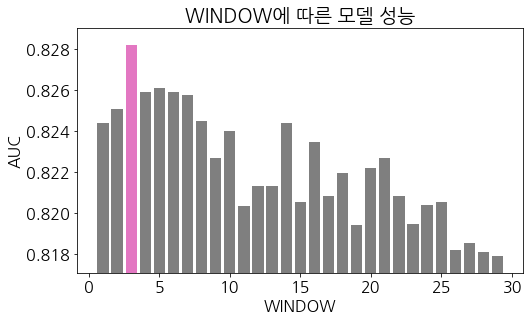

In [238]:
plt.figure(figsize=(8,4.5))
plt.bar(range(1, 1+len(result)), result, color='tab:gray')
plt.bar([3], result[2], color='tab:pink')
# plt.xticks(range(len(result)), range(1, 1+len(result)))
plt.ylim((np.min(result)* 0.999, np.max(result) * 1.001))
plt.xlabel('WINDOW')
plt.ylabel('AUC')
plt.title('WINDOW에 따른 모델 성능')
if img_save:
    plt.savefig('WINDOW에 따른 모델 성능.png')
plt.show()

### 불만 여부에 따른 에러 38 평균값 분석

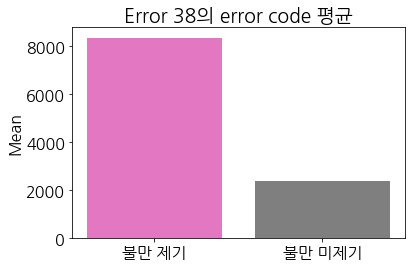

In [239]:
err_38 = err_arr[:,:,-1]
err_38_mean_1 = err_38.sum(axis=1)[problem_user].mean()
err_38_mean_2 = err_38.sum(axis=1)[~problem_user].mean()

plt.bar(range(2), [err_38_mean_1, err_38_mean_2],  color='tab:gray')
plt.bar([0], [err_38_mean_1],  color='tab:pink')
plt.ylim(0,8800)
plt.ylabel('Mean')
plt.title('Error 38의 error code 평균')
plt.xticks(range(2), ['불만 제기','불만 미제기'])
plt.tight_layout()
if img_save:
    plt.savefig('불만 제기 여부에 따른 Error 38의 error code 평균.png', dpi=100)
plt.show()

### 에러 38 합계의 영향 분석

In [240]:
err_arr_sub_1 = err_arr[:,:,-N_ERRTYPE-1:] # 포함
err_arr_sub_2 = err_arr[:,:,-N_ERRTYPE-1:-1] # 불포함

result_38 = []
for data in [err_arr_sub_1, err_arr_sub_2]:
    err_list = []
    for i in range(31 - WINDOW):
        sum_ = np.sum(data[:, i:i + WINDOW, :], axis=1)
        err_list.append(sum_)
    err_r = np.concatenate(
        [np.min(err_list, axis=0), np.max(err_list, axis=0), np.mean(err_list, axis=0),
         np.median(err_list, axis=0), np.std(err_list, axis=0)], axis=1)
    
    _, valid_probs = lgb_train_model(err_r, problem_user, params, 5, categorical_feature = None)
    auc_score = roc_auc_score(problem_user, valid_probs)
    result_38.append(auc_score)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing

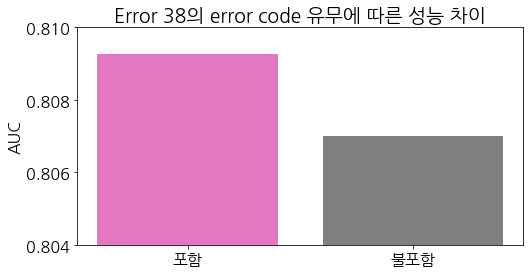

In [241]:
plt.figure(figsize=(8,4))
plt.bar([0], result_38[0], color='tab:pink')
plt.bar([1], result_38[1], color='tab:gray')
plt.xticks(range(2),['포함','불포함'])
plt.ylabel('AUC')
plt.title('Error 38의 error code 유무에 따른 성능 차이')
plt.ylim(0.804, 0.81)
if img_save:
    plt.savefig('에러38.png', dpi=100)
plt.show()

### Quality 수치의 영향 분석

In [242]:
# 데이터 로드 및 전처리
from main import extract_quality_data
qual_df = pd.read_csv(data_path + 'train_quality_data.csv')
qual_df = extract_quality_data(qual_df, 'train')

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7727/7727 [01:39<00:00, 77.36it/s]


### quality의 -1 발생 빈도

In [243]:
# error_df에 quality_df를 concatenate해서 성능 평가
result_minus = []
minus_1_features = ['quality_'+str(i)+'_minus_1_counts' for i in [1, 2, 5, 6, 7, 8, 9, 10, 11, 12]]
train = pd.concat([err_df, qual_df[minus_1_features]], axis=1)
_, valid_probs = lgb_train_model(train, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)

result_minus.append(auc_score)

_, valid_probs = lgb_train_model(err_df, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_minus.append(auc_score)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find

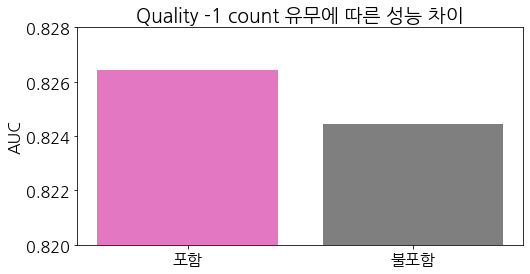

In [244]:
plt.figure(figsize=(8,4))
plt.bar([0], result_minus[0], color='tab:pink')
plt.bar([1], result_minus[1], color='tab:gray')
plt.xticks(range(2),['포함','불포함'])
plt.ylabel('AUC')
plt.title('Quality -1 count 유무에 따른 성능 차이')
plt.ylim(0.82, 0.828)
if img_save:
    plt.savefig('qual_minus_1.png', dpi=100)
plt.show()

### Quality의 높은 수치

In [245]:
# error_df에 quality_df를 concatenate해서 성능 평가
result_intensity = []
intensity_features_mean = ['quality_'+str(i)+'_mean' for i in [1, 2, 5, 6, 7, 8, 9, 10, 11, 12]]
intensity_features_max = ['quality_'+str(i)+'_max' for i in [1, 2, 5, 6, 7, 8, 9, 10, 11, 12]]
intensity_features_std = ['quality_'+str(i)+'_std' for i in [1, 2, 5, 6, 7, 8, 9, 10, 11, 12]]
intensity_features_med = ['quality_'+str(i)+'_med' for i in [1, 2, 5, 6, 7, 8, 9, 10, 11, 12]]
intensity_features = intensity_features_mean + intensity_features_max + intensity_features_std + intensity_features_med


_, valid_probs = lgb_train_model(err_df, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_intensity.append(auc_score)

train = pd.concat([err_df, qual_df[intensity_features_mean]], axis=1)
_, valid_probs = lgb_train_model(train, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)

result_intensity.append(auc_score)

train = pd.concat([err_df, qual_df[intensity_features_max]], axis=1)
_, valid_probs = lgb_train_model(train, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)

result_intensity.append(auc_score)

train = pd.concat([err_df, qual_df[intensity_features_std]], axis=1)
_, valid_probs = lgb_train_model(train, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)

result_intensity.append(auc_score)

train = pd.concat([err_df, qual_df[intensity_features_med]], axis=1)
_, valid_probs = lgb_train_model(train, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)

result_intensity.append(auc_score)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find

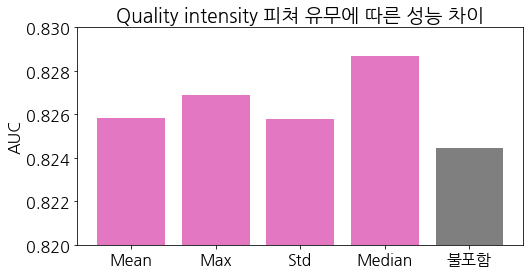

In [246]:
plt.figure(figsize=(8,4))
plt.bar(range(4), result_intensity[1:], color='tab:pink')
plt.bar([4], result_intensity[0], color='tab:gray')
plt.xticks(range(5),['Mean','Max', 'Std','Median', '불포함'])
plt.ylabel('AUC')
plt.title('Quality intensity 피쳐 유무에 따른 성능 차이')
plt.ylim(0.82, 0.83)
if img_save:
    plt.savefig('qual_intensity.png', dpi=100)
plt.show()

### Quality diff count

In [247]:
qual_data = pd.read_csv(data_path + 'train_quality_data.csv')
qual_data.replace(",", "", regex=True, inplace=True)

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [248]:
# 변한 값이 있는지 count
unique_user = np.unique(qual_data['user_id'])
qual_diff_arr = np.zeros((15000, 13), dtype=int)
for user_id in tqdm(unique_user):
    idx = qual_data['user_id'] == user_id
    unique_time = np.unique(qual_data.loc[idx, 'time'])
    for time_ in unique_time:
        time_idx = qual_data.loc[idx, 'time'] == time_
        diff_flag = np.nanstd(qual_data.loc[idx, :].loc[time_idx,'quality_0':'quality_12'].astype(float), axis=0) > 0
        qual_diff_arr[user_id - 10000, :] += diff_flag

  0%|▉                                                                                                                                                                                             | 41/8281 [00:00<02:35, 53.06it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

  2%|███                                                                                                                                                                                          | 134/8281 [00:02<02:09, 63.15it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
  2%|███▏                                                                                                                                                                                         | 141/8281 [00:02<02:36, 51.97it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of f

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
  2%|████                                                                                                                                                           

  3%|██████▏                                                                                                                                                                                      | 272/8281 [00:05<02:00, 66.61it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

  4%|██████▋                                                                                                                                                                                      | 291/8281 [00:05<02:09, 61.47it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

  4%|██████▊                                                                                                                                                                                      | 299/8281 [00:05<02:13, 59.99it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

  5%|████████▊                                                                                                                                                                                    | 387/8281 [00:08<05:01, 26.22it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
  6%|████████████                                                                                                                                                                                 | 527/8281 [00:11<02:13, 58.10it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

  7%|█████████████▎                                                                                                                                                                               | 583/8281 [00:12<02:29, 51.66it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
  9%|████████████████▎                                                                                                                                                                            | 712/8281 [00:16<05:17, 23.80it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 10%|███████████████████▍                                                                                                                                                                         | 851/8281 [00:19<01:47, 69.22it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 10%|███████████████████▋                                                                                                                       

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 12%|██████████████████████▏                                                                                                                                                                      | 973/8281 [00:22<02:31, 48.15it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 12%|██████████████████████▎                                                                                                                                                                      | 979/8281 [00:22<02:47, 43.59it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 13%|████████████████████████▋                                                                                                                                                                   | 1089/8281 [00:24<01:37, 73.60it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 14%|██████████████████████████▊                                                                                                                                                                 | 1181/8281 [00:25<02:16, 51.84it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 14%|██████████████████████████▉                                                                                                                                                                 | 1189/8281 [00:25<02:20, 50.37it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of f

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 15%|███████████████████████████▉                                                                                                                                                                | 1229/8281 [00:27<04:47, 24.51it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 15%|████████████████████████████▍                                                                                                                                                               | 1254/8281 [00:28<03:00, 38.90it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 17%|███████████████████████████████▉                                                                                                                                                            | 1405/8281 [00:34<03:43, 30.73it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 17%|████████████████████████████████▎                                                                                                                                                           | 1423/8281 [00:34<02:48, 40.69it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 19%|███████████████████████████████████▍                                                                                                                                                        | 1563/8281 [00:36<01:18, 85.71it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 20%|█████████████████████████████████████▎                                                                                                                                                      | 1645/8281 [00:38<02:02, 54.07it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 20%|█████████████████████████████████████▋                                                                                                                                                      | 1661/8281 [00:38<02:13, 49.56it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 21%|██████████████████████████████████████▉                                                                                                    

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 23%|███████████████████████████████████████████▋                                                                                                                                                | 1923/8281 [00:45<02:22, 44.59it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 24%|████████████████████████████████████████████▌                                                                                                                                               | 1963/8281 [00:46<01:32, 68.10it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 24%|█████████████████████████████████████████████                                                                                              

 25%|██████████████████████████████████████████████▍                                                                                                                                             | 2048/8281 [00:48<03:39, 28.40it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 25%|███████████████████████████████████████████████▎                                                                                                                                            | 2085/8281 [00:49<01:54, 54.17it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 25%|███████████████████████████████████████████████▋                                                                                                                                            | 2099/8281 [00:49<01:26, 71.36it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of f

 26%|█████████████████████████████████████████████████                                                                                                                                           | 2163/8281 [00:50<02:55, 34.91it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 26%|█████████████████████████████████████████████████▎                                                                                                                                          | 2173/8281 [00:50<02:22, 42.73it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of f

 27%|██████████████████████████████████████████████████▎                                                                                                                                         | 2217/8281 [00:51<02:03, 48.99it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 27%|██████████████████████████████████████████████████▋                                                                                                                                         | 2233/8281 [00:52<02:36, 38.74it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 27%|███████████████████████████████████████████████████▍                                                                   

 28%|█████████████████████████████████████████████████████▍                                                                                                                                      | 2353/8281 [00:55<03:32, 27.92it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 30%|███████████████████████████████████████████████████████▊                                                                                                                                    | 2458/8281 [00:57<01:38, 59.27it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 30%|████████████████████████████████████████████████████████                                                                                                                                    | 2469/8281 [00:57<01:26, 67.05it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of f

 30%|█████████████████████████████████████████████████████████▎                                                                                                                                  | 2524/8281 [00:58<01:53, 50.90it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 31%|█████████████████████████████████████████████████████████▍                                                                                                                                  | 2530/8281 [00:58<02:07, 45.19it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 31%|█████████████████████████████████████████████████████████▋                                                                                                                                  | 2540/8281 [00:58<01:42, 55.76it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of f

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 32%|███████████████████████████████████████████████████████████▋                                                                                                                                | 2627/8281 [01:00<01:43, 54.80it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 32%|███████████████████████████████████████████████████████████▉                                                                                                                                | 2642/8281 [01:00<01:48, 52.03it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 33%|█████████████████████████████████████████████████████████████▊                                                                                                                              | 2721/8281 [01:02<01:56, 47.70it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 34%|███████████████████████████████████████████████████████████████▍                                                                                                                            | 2796/8281 [01:03<01:41, 54.25it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 34%|████████████████████████████████████████████████████████████████▊                                                                                                                           | 2854/8281 [01:05<03:11, 28.29it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 36%|██████████████████████████████████████████████████████████████████▊                                                                                                                         | 2945/8281 [01:09<02:18, 38.57it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 36%|███████████████████████████████████████████████████████████████████▎                                                                                                                        | 2963/8281 [01:11<09:17,  9.53it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 36%|███████████████████████████████████████████████████████████████████▊                                                                       

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 40%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 3297/8281 [01:18<01:59, 41.83it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 41%|████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 3385/8281 [01:21<05:22, 15.17it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 42%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 3456/8281 [01:23<01:40, 47.82it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 42%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 3497/8281 [01:24<01:18, 61.26it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 43%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 3542/8281 [01:24<00:52, 90.61it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of f

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 43%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 3582/8281 [01:25<01:09, 67.36it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 45%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 3767/8281 [01:28<01:14, 60.46it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 46%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 3782/8281 [01:28<01:35, 47.26it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 46%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 3814/8281 [01:29<01:05, 68.45it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of f

 47%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 3926/8281 [01:31<01:33, 46.35it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 48%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 4009/8281 [01:33<01:16, 56.11it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 48%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 4016/8281 [01:33<01:43, 41.23it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 49%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 4036/8281 [01:34<01:40, 42.08it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 49%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 4068/8281 [01:35<01:59, 35.18it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 51%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 4212/8281 [01:38<01:12, 56.27it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 4421/8281 [01:43<02:31, 25.54it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 53%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 4430/8281 [01:44<02:36, 24.66it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 4478/8281 [01:45<01:35, 39.68it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 4617/8281 [01:47<01:38, 37.30it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 4695/8281 [01:48<01:05, 55.08it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 4759/8281 [01:51<02:05, 28.05it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 4863/8281 [01:53<01:50, 30.92it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 4978/8281 [01:55<00:54, 60.37it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 5036/8281 [01:56<00:41, 77.89it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 5080/8281 [01:58<01:12, 44.01it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 5123/8281 [01:58<01:04, 48.71it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 5139/8281 [01:59<01:01, 51.44it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of f

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 5219/8281 [02:00<00:37, 82.37it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 5247/8281 [02:01<01:17, 39.05it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 5264/8281 [02:01<00:59, 50.44it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of f

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 5446/8281 [02:05<01:02, 45.13it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 5496/8281 [02:06<00:54, 51.17it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 5524/8281 [02:06<00:44, 62.10it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of f

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 5573/8281 [02:08<01:20, 33.51it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 5658/8281 [02:10<01:25, 30.59it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 5686/8281 [02:11<01:59, 21.74it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 5696/8281 [02:12<01:44, 24.76it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 5746/8281 [02:12<00:41, 61.67it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 5840/8281 [02:15<00:57, 42.30it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 5903/8281 [02:18<02:31, 15.65it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 5930/8281 [02:18<00:56, 41.94it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of f

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 6103/8281 [02:22<01:34, 22.93it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 6183/8281 [02:24<00:31, 66.12it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 6230/8281 [02:25<00:33, 60.61it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 6280/8281 [02:26<00:47, 42.49it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 6401/8281 [02:28<00:24, 77.83it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 6557/8281 [02:32<00:54, 31.85it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 6599/8281 [02:33<00:53, 31.24it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 6670/8281 [02:34<00:27, 59.46it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 6735/8281 [02:36<00:58, 26.45it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 6750/8281 [02:37<00:52, 29.24it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 6764/8281 [02:37<00:38, 39.49it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of f

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 6799/8281 [02:38<00:35, 41.68it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 6921/8281 [02:40<00:36, 37.21it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 7122/8281 [02:46<00:33, 34.70it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 7216/8281 [02:48<00:14, 75.76it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 7245/8281 [02:50<00:53, 19.27it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 7287/8281 [02:51<00:20, 47.87it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 7367/8281 [02:53<00:12, 71.09it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 7458/8281 [02:55<00:21, 38.61it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 7520/8281 [02:56<00:12, 61.78it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 7551/8281 [02:57<00:17, 42.67it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 7716/8281 [03:01<00:27, 20.60it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 7725/8281 [03:01<00:19, 27.88it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of f

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 7810/8281 [03:03<00:09, 48.36it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 8052/8281 [03:09<00:07, 28.76it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 8109/8281 [03:10<00:04, 41.02it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 8153/8281 [03:11<00:02, 60.74it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 8229/8281 [03:13<00:01, 28.59it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 8241/8281 [03:14<00:01, 24.90it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of f

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 8256/8281 [03:14<00:00, 35.61it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a,

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 8267/8281 [03:15<00:00, 27.13it/s]C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\envs\dash-datashader\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slic

In [249]:
# concatenate
result_diff = []
con = pd.concat([err_df, pd.DataFrame(qual_diff_arr)], axis=1)
_, valid_probs = lgb_train_model(con.values, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_diff.append(auc_score)

# 원본
_, valid_probs = lgb_train_model(err_df, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_diff.append(auc_score)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.0292

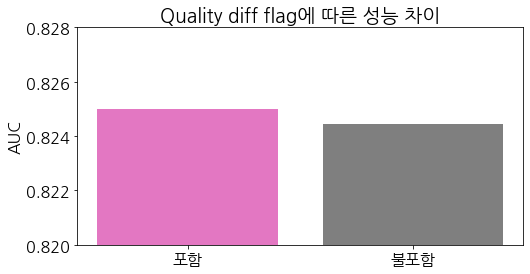

In [250]:
plt.figure(figsize=(8,4))
plt.bar([0], result_diff[0], color='tab:pink')
plt.bar([1], result_diff[1], color='tab:gray')
plt.xticks(range(2),['포함','불포함'])
plt.ylabel('AUC')
plt.title('Quality diff flag에 따른 성능 차이')
plt.ylim(0.82, 0.828)
if img_save:
    plt.savefig('qual_diff.png', dpi=100)
plt.show()

### quality의 평균과 불만 여부의 관계

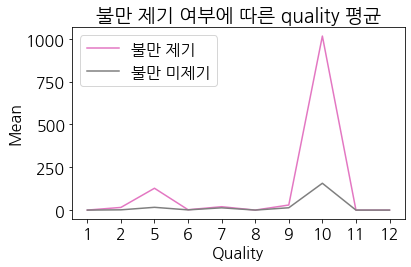

In [251]:
plt.plot(qual_df[intensity_features_mean][problem_user].mean(axis=0), label='불만 제기', color='tab:pink')
plt.plot(qual_df[intensity_features_mean][~problem_user].mean(axis=0), label='불만 미제기', color='tab:gray')
plt.xticks(range(len([1, 2, 5, 6, 7, 8, 9, 10, 11, 12])),[1, 2, 5, 6, 7, 8, 9, 10, 11, 12])
plt.xlabel('Quality')
plt.ylabel('Mean')
plt.title('불만 제기 여부에 따른 quality 평균')
plt.legend()
plt.tight_layout()
if img_save:
    plt.savefig('불만 제기 여부에 따른 quality 평균.png', dpi=100)
plt.show()

### 불만 제기 여부에 따른 -1의 발생 빈도

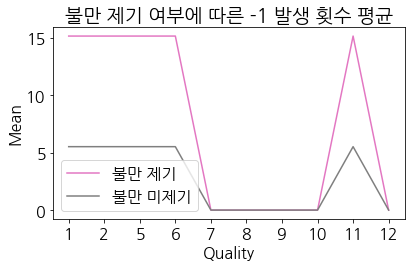

In [252]:
minus_1_features = ['quality_'+str(i)+'_minus_1_counts' for i in [1, 2, 5, 6, 7, 8, 9, 10, 11, 12]]
plt.plot(qual_df[minus_1_features][problem_user].mean(axis=0), label='불만 제기', color='tab:pink')
plt.plot(qual_df[minus_1_features][~problem_user].mean(axis=0), label='불만 미제기', color='tab:gray')
plt.xticks(range(len([1, 2, 5, 6, 7, 8, 9, 10, 11, 12])),[1, 2, 5, 6, 7, 8, 9, 10, 11, 12])
plt.xlabel('Quality')
plt.ylabel('Mean')
plt.title('불만 제기 여부에 따른 -1 발생 횟수 평균')
plt.legend()
plt.tight_layout()
if img_save:
    plt.savefig('불만 제기 여부에 따른 -1 발생 횟수 평균.png', dpi=100)
plt.show()

### 불만 제기 여부에 따른 2시간 내 quality 변화 빈도

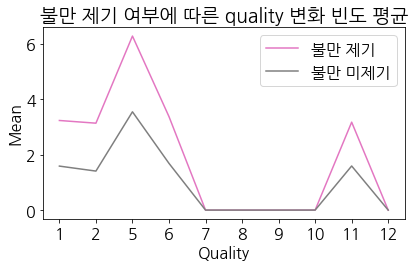

In [253]:
use_idx = np.array([1, 2, 5, 6, 7, 8, 9, 10, 11, 12])
plt.plot(qual_diff_arr[problem_user, :].mean(axis=0)[use_idx], label='불만 제기', color='tab:pink')
plt.plot(qual_diff_arr[~problem_user, :].mean(axis=0)[use_idx], label='불만 미제기', color='tab:gray')

plt.xticks(range(len(use_idx)),use_idx)
plt.xlabel('Quality')
plt.ylabel('Mean')
plt.title('불만 제기 여부에 따른 quality 변화 빈도 평균')
plt.legend()
plt.tight_layout()
if img_save:
    plt.savefig('불만 제기 여부에 따른 quality 변화 빈도 평균.png', dpi=100)
plt.show()

### model_nm 모델 성능 평가

In [254]:
# 1. model 유무 피쳐
feature_model = ['model_'+str(i) for i in range(9)]
result_model = []
con = pd.concat([err_df, model_df[feature_model]], axis=1)
_, valid_probs = lgb_train_model(con.values, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_model.append(auc_score)

# 2. 모델 업그레이드
con = pd.concat([err_df, model_df['model_upgrade']], axis=1)
_, valid_probs = lgb_train_model(con.values, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_model.append(auc_score)

# 2. 모델 다운그레이드
con = pd.concat([err_df, model_df['model_downgrade']], axis=1)
_, valid_probs = lgb_train_model(con.values, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_model.append(auc_score)

# 3. 모델 변경
con = pd.concat([err_df, model_df['model_diff']], axis=1)
_, valid_probs = lgb_train_model(con.values, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_model.append(auc_score)

# 4. 불포함
_, valid_probs = lgb_train_model(err_df.values, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_model.append(auc_score)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM]

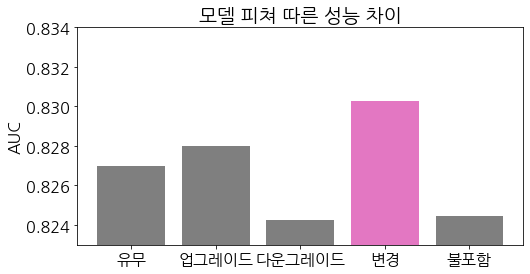

In [255]:
plt.figure(figsize=(8,4))
plt.bar(range(5), result_model, color='tab:gray')
plt.bar([3], result_model[3], color='tab:pink')
plt.xticks(range(5),['유무', '업그레이드','다운그레이드', '변경','불포함'])
plt.ylabel('AUC')
plt.title('모델 피쳐 따른 성능 차이')
plt.ylim(0.823, 0.834)
if img_save:
    plt.savefig('model_features.png', dpi=100)
plt.show()

### 펌웨어 첫째자리 사용에 따른 모델 성능 차이

In [256]:
result_fwver = []

# 2. fwver 업그레이드
con = pd.concat([err_df, fwver_df['fwver_upgrade_0']], axis=1)
_, valid_probs = lgb_train_model(con.values, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_fwver.append(auc_score)

# 2. fwver 다운그레이드
con = pd.concat([err_df, fwver_df['fwver_downgrade_0']], axis=1)
_, valid_probs = lgb_train_model(con.values, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_fwver.append(auc_score)

# 3. fwver 변경
con = pd.concat([err_df, fwver_df['fwver_diff_1']], axis=1)
_, valid_probs = lgb_train_model(con.values, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_fwver.append(auc_score)

# 4. fwver 불포함
_, valid_probs = lgb_train_model(err_df.values, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_fwver.append(auc_score)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM]

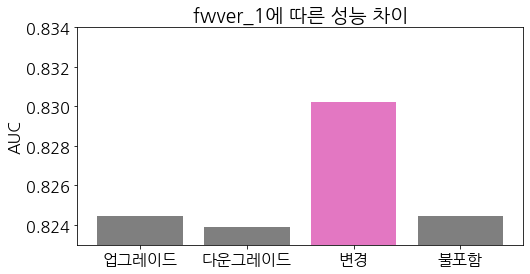

In [257]:
plt.figure(figsize=(8,4))
plt.bar(range(4), result_fwver, color='tab:gray')
plt.bar([2], result_fwver[2], color='tab:pink')
plt.xticks(range(4),['업그레이드','다운그레이드', '변경','불포함'])
plt.ylabel('AUC')
plt.title('fwver_1에 따른 성능 차이')
plt.ylim(0.823, 0.834)
if img_save:
    plt.savefig('fwver_features.png', dpi=100)
plt.show()

### fwver 세분화에 따른 성능 비교 (변경만)

In [258]:
result_fwver_vs = []

# 1. 첫째자리
con = pd.concat([err_df, fwver_df['fwver_diff_0']], axis=1)
_, valid_probs = lgb_train_model(con.values, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_fwver_vs.append(auc_score)

# 2. 둘째자리 (model 변경과 동일)
con = pd.concat([err_df, fwver_df['fwver_diff_1']], axis=1)
_, valid_probs = lgb_train_model(con.values, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_fwver_vs.append(auc_score)

# 3. 셋째자리
con = pd.concat([err_df, fwver_df['fwver_diff_2']], axis=1)
_, valid_probs = lgb_train_model(con.values, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_fwver_vs.append(auc_score)

# 4. 불포함
_, valid_probs = lgb_train_model(err_df.values, problem_user, params, 5, categorical_feature = None)
auc_score = roc_auc_score(problem_user, valid_probs)
result_fwver_vs.append(auc_score)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM]

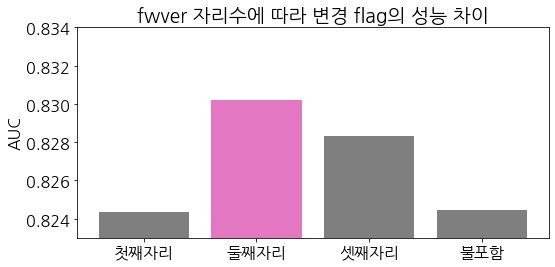

In [259]:
plt.figure(figsize=(8,4))
plt.bar(range(4), result_fwver_vs, color='tab:gray')
plt.bar([1], result_fwver_vs[1], color='tab:pink')
plt.xticks(range(4),['첫째자리','둘째자리', '셋째자리','불포함'])
plt.ylabel('AUC')
plt.title('fwver 자리수에 따라 변경 flag의 성능 차이')
plt.ylim(0.823, 0.834)
plt.tight_layout()
if img_save:
    plt.savefig('fwver_features_versions.png', dpi=100)
plt.show()